In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [246]:
customer_df = pd.read_csv('files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv')
customer_df.columns= customer_df.columns.str.strip().str.lower()
customer_df.columns = customer_df.columns.str.replace(' ', '_')
categoricals = customer_df.select_dtypes(object)

# Some values should be consolidated   
def clean_education(x):
    if x in ['Master', 'Doctor']:
        return 'Post-College'
    else:
        return x    
    
def clean_employmentstatus(x):
    if x in ['Medical Leave', 'Disabled', 'Retired']:
        return 'Others'
    else:
        return x 
    
def clean_maritalstatus(x):
    if x in ['Single', 'Divorced']:
        return 'Non Married'
    else:
        return x   
    
def clean_policytype(x):
    if x in ['Corporate Auto', 'Special Auto']:
        return 'Non Personal Auto'
    else:
        return x    
    
def clean_policy(x):
    if x in ['Personal L1', 'Corporate L1', 'Special L1']:
        return 'L1'
    elif x in ['Personal L2', 'Corporate L2', 'Special L2']:
        return 'L2'
    else:
        return 'L3'  
    
def clean_vehicleclass(x):
    if x in ['Sports Car', 'Luxury Car', 'Luxury SUV']:
        return 'Sports/Luxury'
    else:
        return x       


In [247]:
customer_df.loc[:,'education'] = customer_df['education'].apply(clean_education)    
customer_df.loc[:,'employmentstatus'] = customer_df['employmentstatus'].apply(clean_employmentstatus)    
customer_df.loc[:,'marital_status'] = customer_df['marital_status'].apply(clean_maritalstatus)    
customer_df.loc[:,'policy_type'] = customer_df['policy_type'].apply(clean_policytype)    
customer_df.loc[:,'policy'] = customer_df['policy'].apply(clean_policy)    
customer_df.loc[:,'vehicle_class'] = customer_df['vehicle_class'].apply(clean_vehicleclass)    

customer_df.loc[:,'effective_to_date'] = pd.DatetimeIndex(customer_df.loc[:,'effective_to_date'])

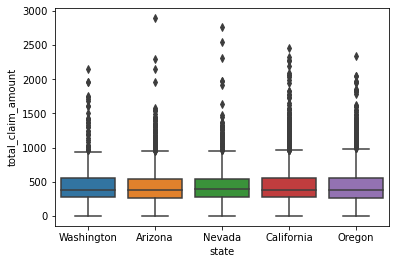

California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: state, dtype: int64

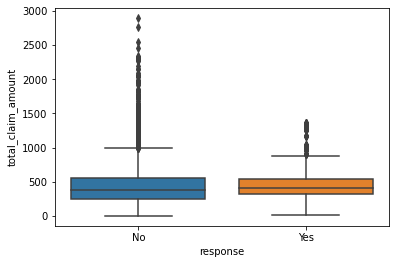

No     7826
Yes    1308
Name: response, dtype: int64

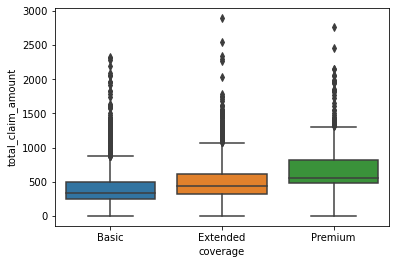

Basic       5568
Extended    2742
Premium      824
Name: coverage, dtype: int64

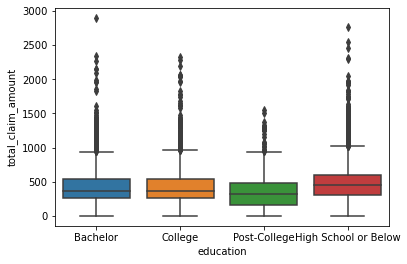

Bachelor                2748
College                 2681
High School or Below    2622
Post-College            1083
Name: education, dtype: int64

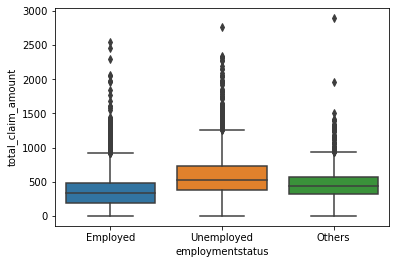

Employed      5698
Unemployed    2317
Others        1119
Name: employmentstatus, dtype: int64

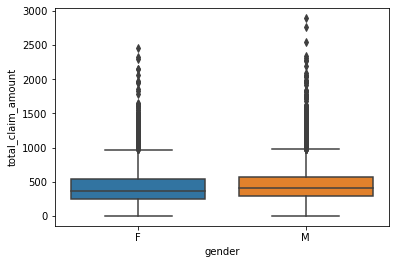

F    4658
M    4476
Name: gender, dtype: int64

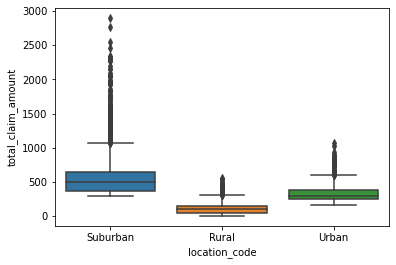

Suburban    5779
Rural       1773
Urban       1582
Name: location_code, dtype: int64

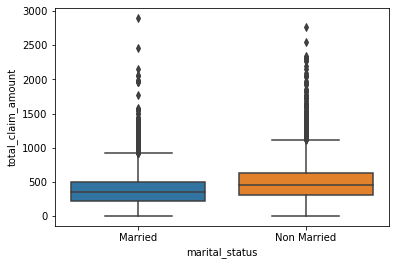

Married        5298
Non Married    3836
Name: marital_status, dtype: int64

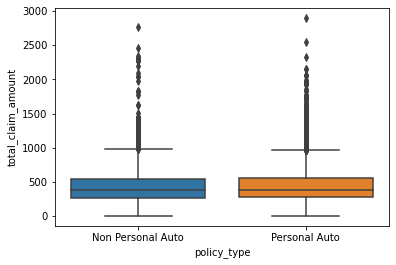

Personal Auto        6788
Non Personal Auto    2346
Name: policy_type, dtype: int64

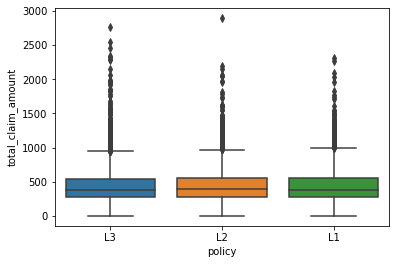

L3    4588
L2    2881
L1    1665
Name: policy, dtype: int64

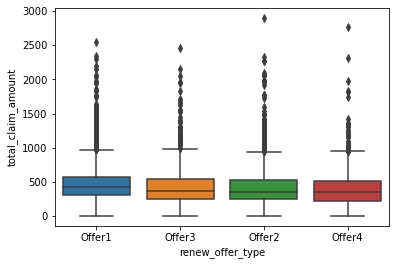

Offer1    3752
Offer2    2926
Offer3    1432
Offer4    1024
Name: renew_offer_type, dtype: int64

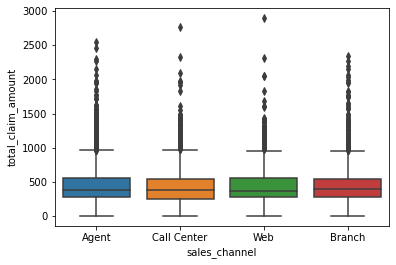

Agent          3477
Branch         2567
Call Center    1765
Web            1325
Name: sales_channel, dtype: int64

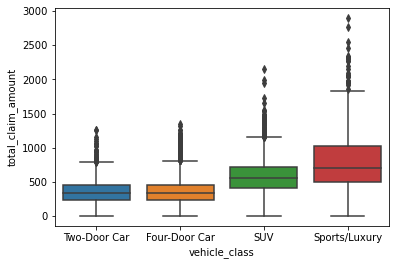

Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports/Luxury     831
Name: vehicle_class, dtype: int64

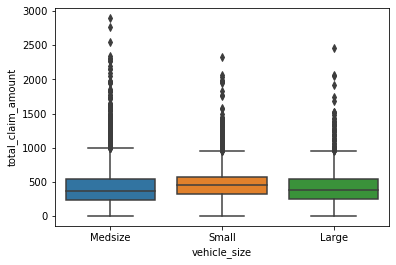

Medsize    6424
Small      1764
Large       946
Name: vehicle_size, dtype: int64

In [248]:
#categorical variables
for column in customer_df.select_dtypes(object).drop(['customer'], axis=1):
    sns.boxplot(x=customer_df[column], y=customer_df['total_claim_amount'], data=customer_df)
    plt.show()
    display(customer_df[column].value_counts())

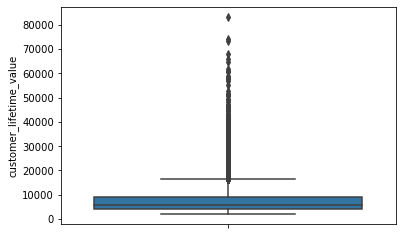

2248.449633     6
10972.067780    6
5619.689084     6
11981.984810    6
2530.705137     6
               ..
12349.702320    1
4046.936065     1
2121.313061     1
7232.609391     1
3297.904615     1
Name: customer_lifetime_value, Length: 8041, dtype: int64

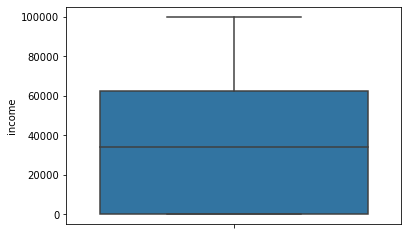

0        2317
95697      12
26876       7
61108       7
25965       7
         ... 
36259       1
69011       1
38638       1
30092       1
51199       1
Name: income, Length: 5694, dtype: int64

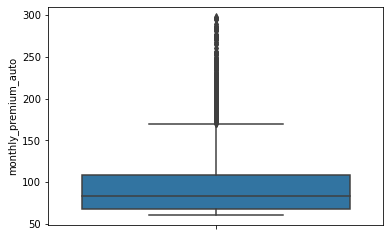

65     348
66     307
71     304
73     302
63     289
      ... 
147      1
290      1
273      1
298      1
205      1
Name: monthly_premium_auto, Length: 202, dtype: int64

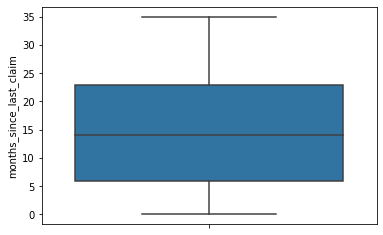

3     381
6     364
1     345
4     335
7     333
2     329
0     314
5     313
10    306
11    297
16    295
15    286
13    285
8     279
12    273
14    268
17    263
9     250
19    246
23    239
25    236
21    233
20    231
18    229
22    218
24    211
29    206
28    201
31    190
26    186
30    182
27    182
33    179
34    169
35    142
32    138
Name: months_since_last_claim, dtype: int64

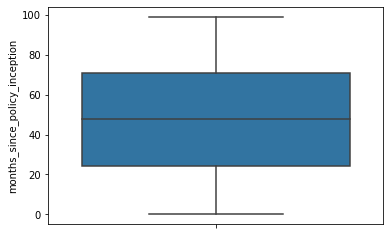

59    142
61    128
50    125
44    115
10    114
     ... 
16     70
96     67
82     56
98     54
97     52
Name: months_since_policy_inception, Length: 100, dtype: int64

In [249]:
#numerical variables
for column in customer_df.select_dtypes(np.number).drop(['total_claim_amount', 'number_of_open_complaints', 'number_of_policies'], axis=1):
    sns.boxplot(y=customer_df[column])
    plt.show()
    display(customer_df[column].value_counts())

In [250]:
# function to remove the outliers
# in first loop I calculate the upper_limits and in the second loop I remove them from the data
# I don't do it in the same loop because after removing some rows, the following upperlimits would change
def outliers (data):
    upperlimits_list = []
    numericals = data.select_dtypes(np.number).drop(['total_claim_amount', 'number_of_open_complaints', 'number_of_policies'], axis=1)
    for column in numericals.columns:
        iqr = np.percentile(data[column],75) - np.percentile(data[column],25)
        upper_limit = np.percentile(data[column],75) + 2*iqr
        upperlimits_list.append([upper_limit, column])
    for x in range(len(upperlimits_list)):
        data = data[data[upperlimits_list[x][1]] <= upperlimits_list[x][0]]
    return data
    

In [251]:
customer_df = outliers(customer_df)


In [252]:
data = customer_df.copy().reset_index()

In [253]:
continuous_df = data.select_dtypes(float).drop(['total_claim_amount'], axis=1)
discrete_df = data.select_dtypes(include=['int64']).drop(['index'], axis=1)

In [254]:
X_normalized = pd.DataFrame(MinMaxScaler().fit_transform(continuous_df), columns=continuous_df.columns)

In [255]:
X_normalized

,customer_lifetime_value
0,0.050930
1,0.299016
2,0.646658
3,0.338225
4,0.053882
...,...
8308,0.129597
8309,0.070524
8310,0.368707
8311,0.331080


In [256]:
ordinal_encoded = data[['coverage', 'employmentstatus', 'location_code', 'vehicle_size']]
ordinal_encoded.loc[:,"coverage"] = ordinal_encoded["coverage"].map({"Basic" : 0, "Extended" : 1, "Premium" : 2})
ordinal_encoded.loc[:,"employmentstatus"] = ordinal_encoded["employmentstatus"].map({"Employed" : 0, "Unemployed" : 1, "Others" : 2})
ordinal_encoded.loc[:,"location_code"] = ordinal_encoded["location_code"].map({"Urban" : 0, "Suburban" : 1, "Rural" : 2})
ordinal_encoded.loc[:,"vehicle_size"] = ordinal_encoded["vehicle_size"].map({"Small" : 0, "Medsize" : 1, "Large" : 2})


C:\Users\Ferran\anaconda3\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\Ferran\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [257]:
onehot = data[['response', 'education', 'gender', 'state', 'marital_status', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class']]
onehot_encoded = pd.get_dummies(onehot, 
                            columns=['response', 'education', 'gender','state', 'marital_status', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class'],
                            drop_first=True)
onehot_encoded

,response_Yes,education_College,education_High School or Below,education_Post-College,gender_M,state_California,state_Nevada,state_Oregon,state_Washington,marital_status_Non Married,...,policy_L3,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_SUV,vehicle_class_Sports/Luxury,vehicle_class_Two-Door Car
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8308,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
8309,1,1,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
8310,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
8311,0,1,0,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [258]:
cat_encoded = pd.concat([onehot_encoded, ordinal_encoded], axis=1)

In [259]:
cat_encoded.shape

(8313, 26)

In [260]:
data['day'] = pd.DatetimeIndex(data['effective_to_date']).day
data['month'] = pd.DatetimeIndex(data['effective_to_date']).month
data = data.drop(['effective_to_date'], axis=1)

In [261]:
data.head()

,index,customer,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,...,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,day,month
0,0,BU79786,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,...,1,Non Personal Auto,L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,24,2
1,1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,...,8,Personal Auto,L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,31,1
2,2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,...,2,Personal Auto,L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,19,2
3,3,WW63253,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,...,7,Non Personal Auto,L2,Offer1,Call Center,529.881344,SUV,Medsize,20,1
4,4,HB64268,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,...,1,Personal Auto,L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,3,2


In [262]:
data = pd.concat([X_normalized, onehot_encoded, ordinal_encoded, data['day'], data['month'], data['total_claim_amount']], axis=1)


In [263]:
data.dtypes

customer_lifetime_value           float64
response_Yes                        uint8
education_College                   uint8
education_High School or Below      uint8
education_Post-College              uint8
gender_M                            uint8
state_California                    uint8
state_Nevada                        uint8
state_Oregon                        uint8
state_Washington                    uint8
marital_status_Non Married          uint8
policy_type_Personal Auto           uint8
policy_L2                           uint8
policy_L3                           uint8
renew_offer_type_Offer2             uint8
renew_offer_type_Offer3             uint8
renew_offer_type_Offer4             uint8
sales_channel_Branch                uint8
sales_channel_Call Center           uint8
sales_channel_Web                   uint8
vehicle_class_SUV                   uint8
vehicle_class_Sports/Luxury         uint8
vehicle_class_Two-Door Car          uint8
coverage                          

In [264]:
data.shape

(8313, 30)

In [265]:
import pickle
data.to_pickle('data.p')
